In [51]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from IPython.display import Image

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [173]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [174]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

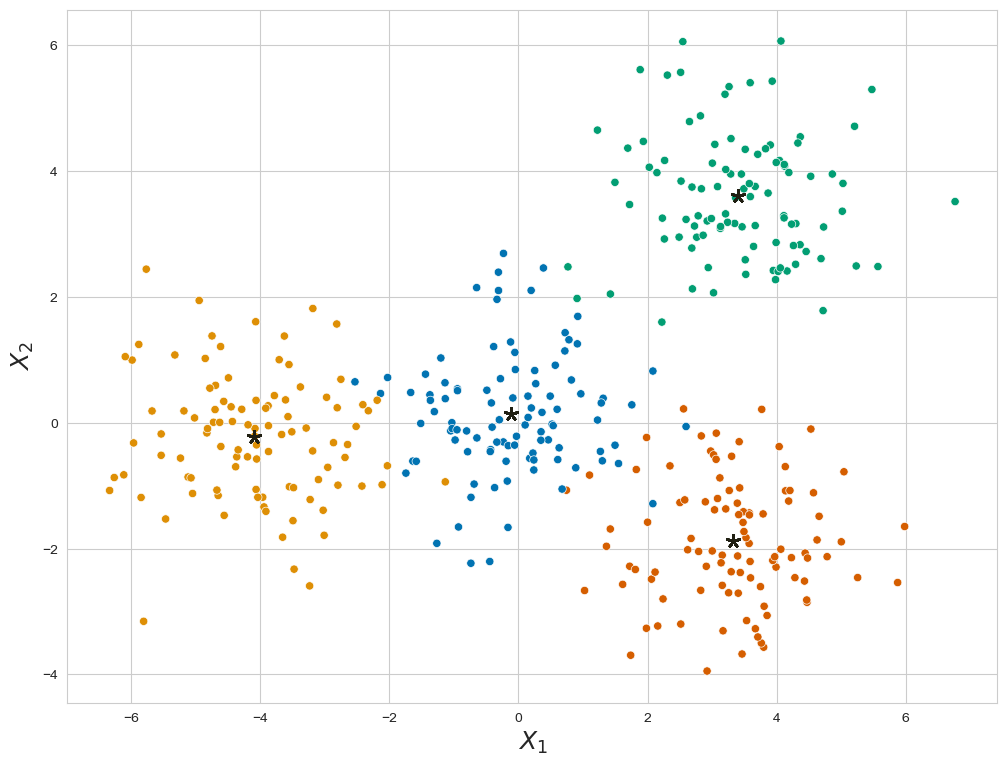

In [175]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [176]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = [array.reshape(-1, 1) for array in dists]
            dists = np.concatenate(dists, axis=1)
             # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = [array.reshape(-1, 1) for array in dists]
        dists = np.concatenate(dists, axis=1)
            
        # Для каждого объекта найдем, к какому центроиду он ближе
        cluster_labels = np.argmin(dists, axis=1)

        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        dist = np.sqrt(np.sum((X - centroid)**2, axis=1))

        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

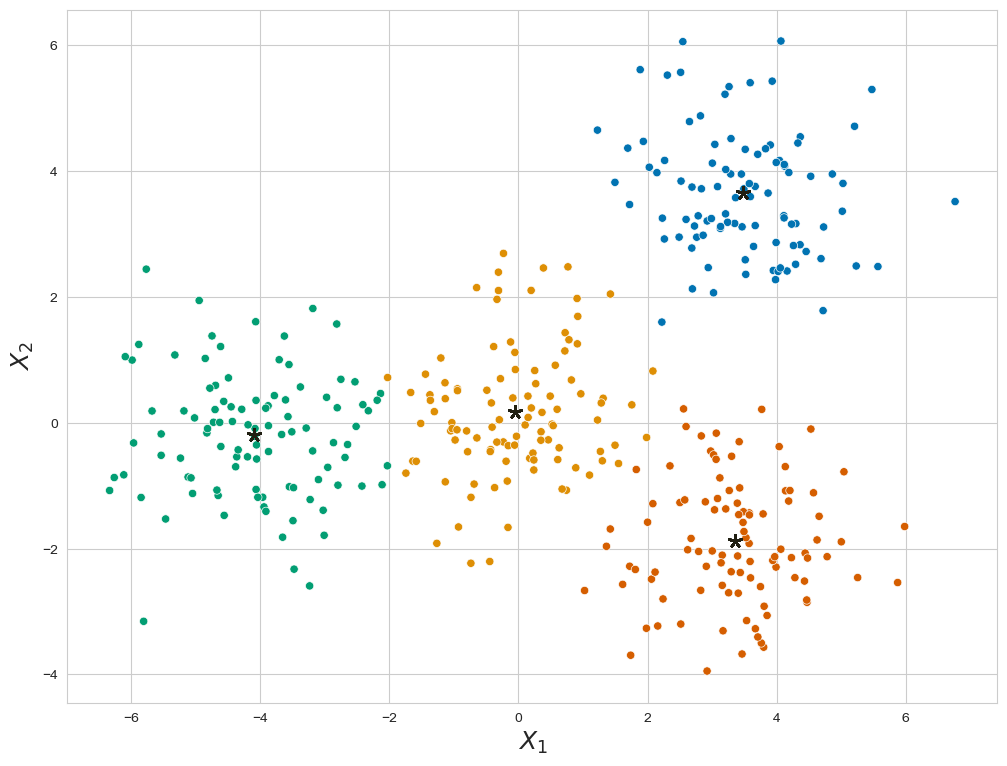

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [177]:
# Обучим модель
k_means = MyKMeans(4, max_iter=30, visualize=True)
k_means.fit(X)

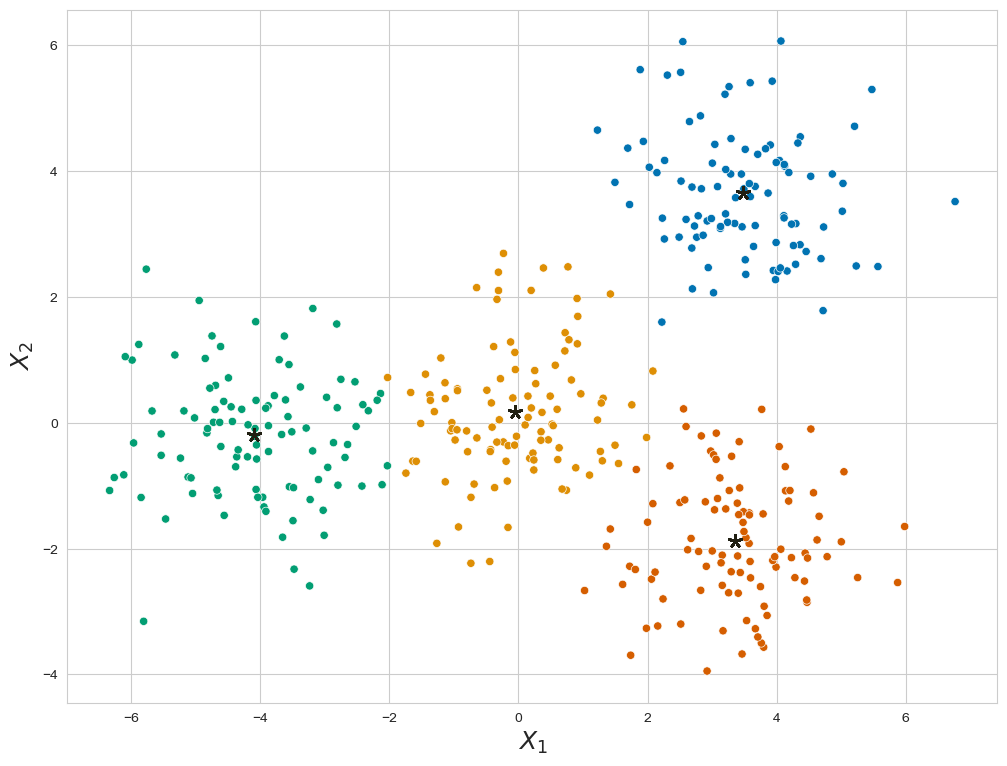

In [178]:
# Предскажем
predict_labels = k_means.predict(X)
visualize_clusters(X, predict_labels)

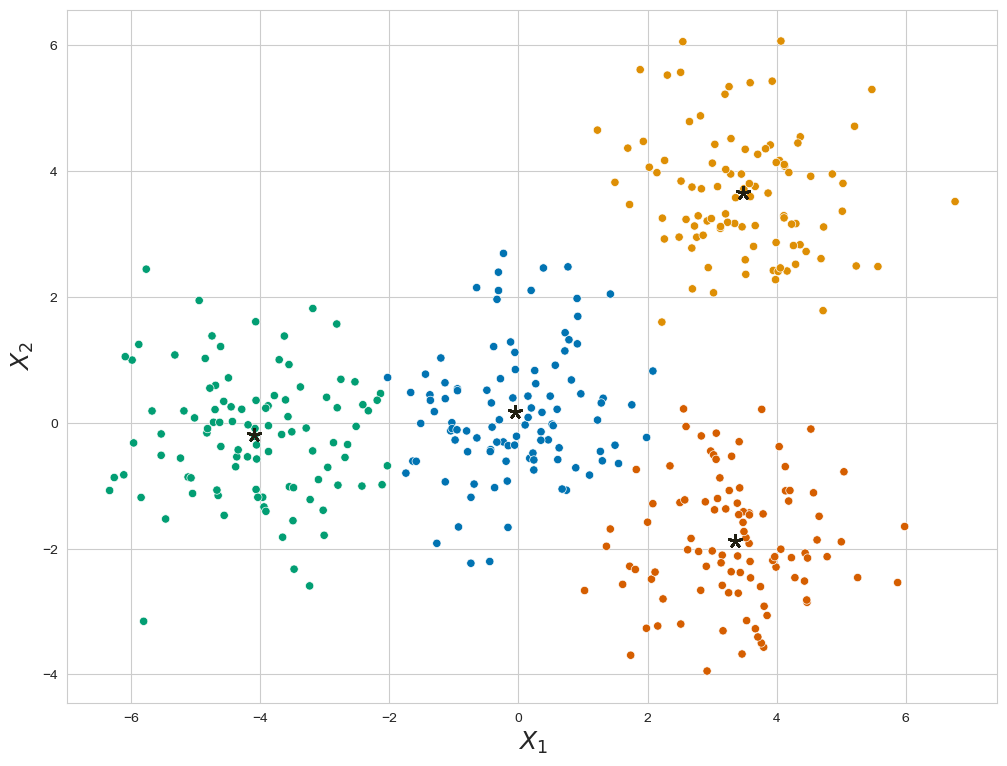

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [180]:
# Обучим модель с init "sample"
k_means = MyKMeans(4, max_iter=30, visualize=True, init="sample")
k_means.fit(X)

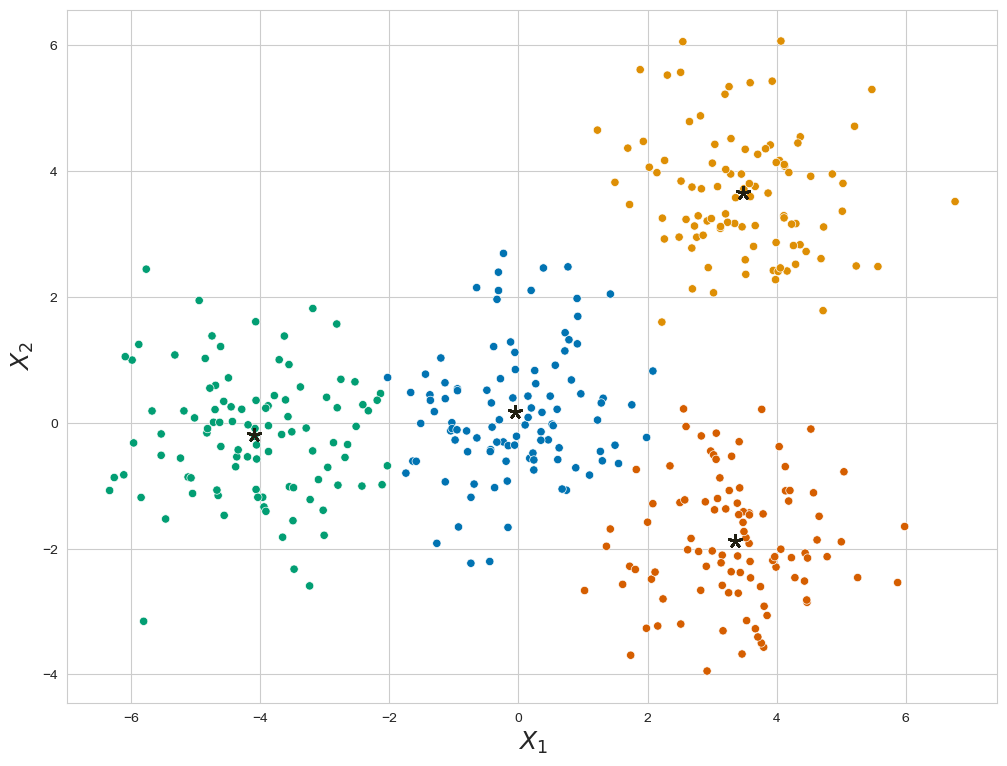

In [182]:
# Предскажем
predict_labels = k_means.predict(X)
visualize_clusters(X, predict_labels)

Кажется, что в данном примере не было видно разницы между моделью, которая генерирует координаты случайно из нормального распределения и той, которая выбирает центроиды случайно из объектов выборки. Обе хорошо разделили кластеры.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [183]:
data = load_digits()
X, y = data.data, data.target

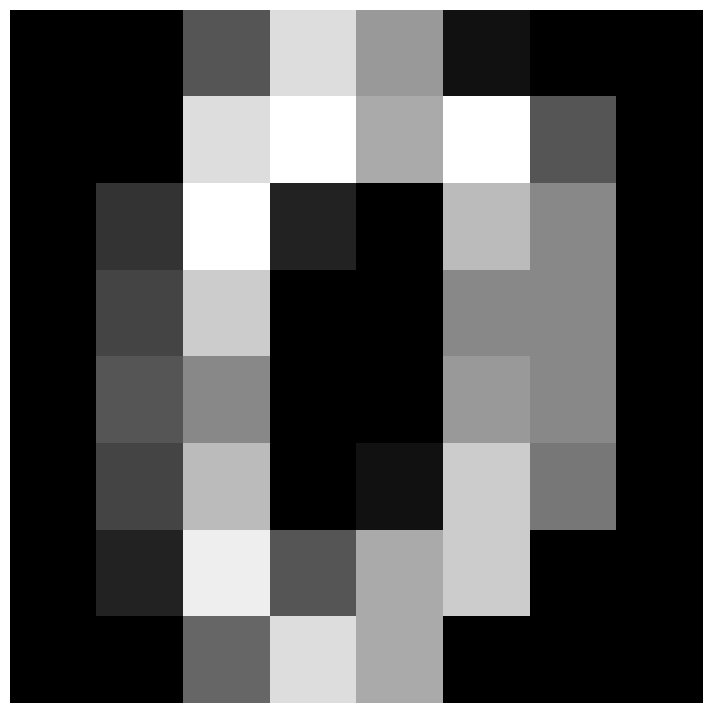

In [184]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [185]:
def algorithm_selection(X, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    compare_dataframe = [["Distance", "Linkage", "Homogeneity", "completeness", "v_measure", "silhouette"]]

    
    for distance in distances:
        for algorithm in algorithms:
            model = AgglomerativeClustering(n_clusters = 10, metric = distance, linkage = algorithm)
            labels = model.fit_predict(X)
            homogeneity = homogeneity_score(y, labels)
            completeness = completeness_score(y, labels)
            v_measure = v_measure_score(y, labels)
            silhouette = silhouette_score(X, labels)
            compare_dataframe.append([distance, algorithm, homogeneity, completeness, v_measure, silhouette])
            
    return pd.DataFrame(compare_dataframe[1:], columns=compare_dataframe[0])

In [186]:
distnances = ["euclidean", "l1", "l2", "manhattan", "cosine"]
algorithms = ['average', 'single', 'complete']
metrics = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette']
algorithm_selection(X, distnances, algorithms, metrics)

,Distance,Linkage,Homogeneity,completeness,v_measure,silhouette
0,euclidean,average,0.655393,0.782342,0.713263,0.146625
1,euclidean,single,0.005056,0.273755,0.009929,-0.133621
2,euclidean,complete,0.590549,0.637772,0.613253,0.119271
3,l1,average,0.566751,0.778942,0.656117,0.089217
4,l1,single,0.005102,0.276237,0.010019,-0.166627
5,l1,complete,0.646372,0.686109,0.665648,0.140183
6,l2,average,0.655393,0.782342,0.713263,0.146625
7,l2,single,0.005056,0.273755,0.009929,-0.133621
8,l2,complete,0.590549,0.637772,0.613253,0.119271
9,manhattan,average,0.566751,0.778942,0.656117,0.089217


Строки 0, 6 и 12 указывают на лучшие алгоритмы из протестированных, так как все четыре метрики представленные здесь в идеале должны стремиться к 1. Хотя как мне кажется силуэтт 0.14 говорит о том, что данные разделены плохо.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [3]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [4]:
fc_data.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.962458,0.165415,1.791579,3.280391,5.169845,1.097182,0.412223,1.219683,0.569898
std,0.500012,0.190773,2.027281,2.112079,0.518247,1.375876,1.176967,2.285305,1.502445
min,0.144786,0.021657,-7.634172,-2.517639,-8.329666,-8.833883,-12.358701,-9.640775,-11.085437
25%,0.798804,0.105550,0.275056,1.401943,4.922227,0.389746,-0.195978,-0.146948,-0.498781
50%,0.908574,0.130543,1.194313,4.373660,5.234119,0.672853,0.053267,0.244121,0.272297
75%,1.052034,0.162536,3.696976,4.842212,5.481218,1.065076,0.378576,0.908374,1.220576
max,42.954485,15.460997,12.946668,13.844391,13.710922,6.294236,6.461899,7.208721,6.840864


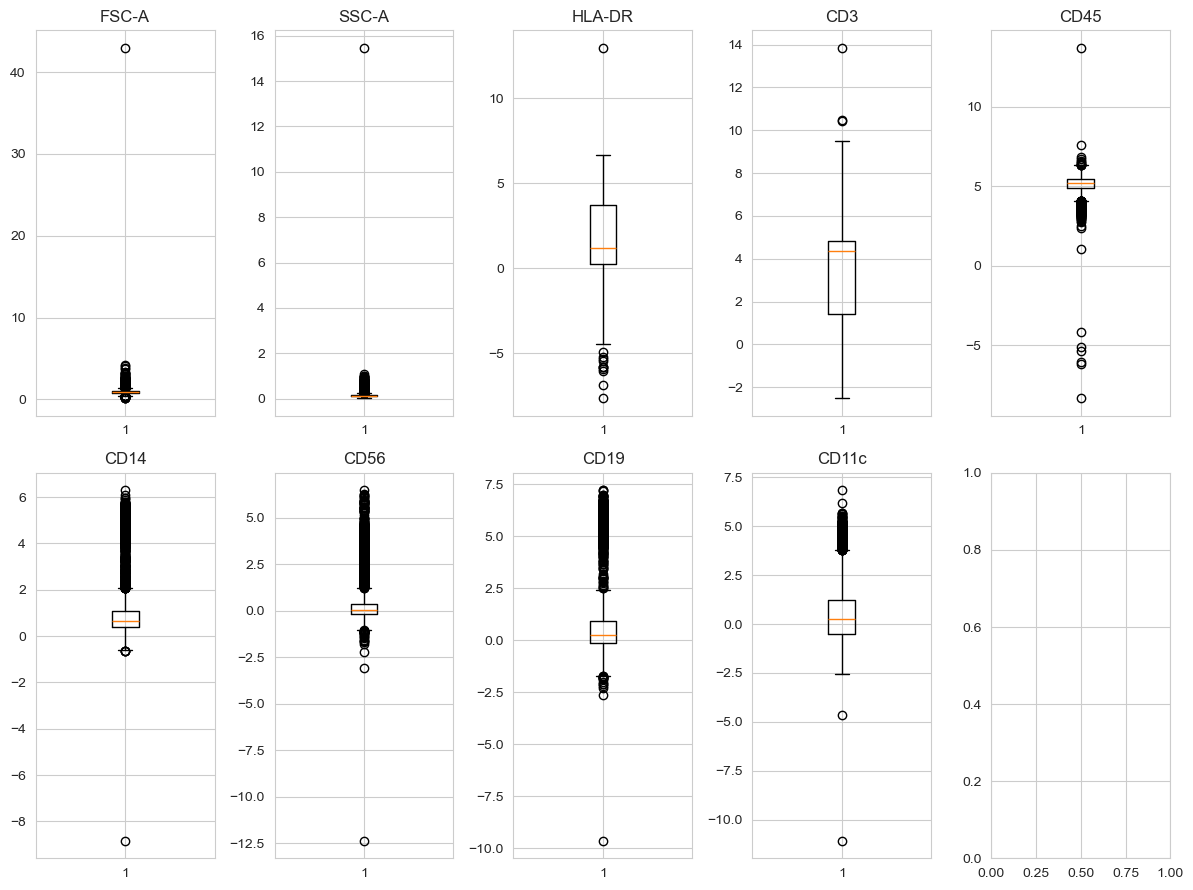

In [5]:
columns = fc_data.columns.tolist()
num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols)

for i in range(len(columns)):
    ax = axes[i // num_cols, i % num_cols]
    ax.boxplot(fc_data.iloc[:, i])
    ax.set_title(columns[i]) 


plt.tight_layout()
plt.show()

У нас 10000 клеток и 9 признаков. Кажется что есть немало выбросов. Выбросы (а именно одно значение, которое очень высокое) из первых двух признаков, которые коррелируют с размером клетки стоит убрать. Из других признаков я не буду убирать выбросы, так как не знаю вдруг определенный маркер и правда так сильно представлен у некоторых клеток.

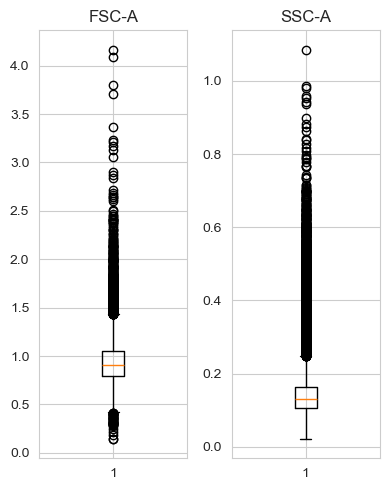

In [6]:
max_value = fc_data["FSC-A"].max()
fc_data = fc_data[fc_data["FSC-A"] < max_value]

columns = fc_data.columns.tolist()
num_cols = 2
fig, axes = plt.subplots(1, num_cols, figsize=(4, 5))

for i in range(2):
    ax = axes[i]
    ax.boxplot(fc_data.iloc[:, i])
    ax.set_title(columns[i]) 


plt.tight_layout()
plt.show()

 Кроме того, значения признаков отличаются по своим значениям (среднее для некоторых меньше 1, а для некоторых 5), поэтому стандартизуем их.

In [7]:
scaler = StandardScaler()

scaler.fit(fc_data)
scaled_fc_data = scaler.transform(fc_data)

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [8]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

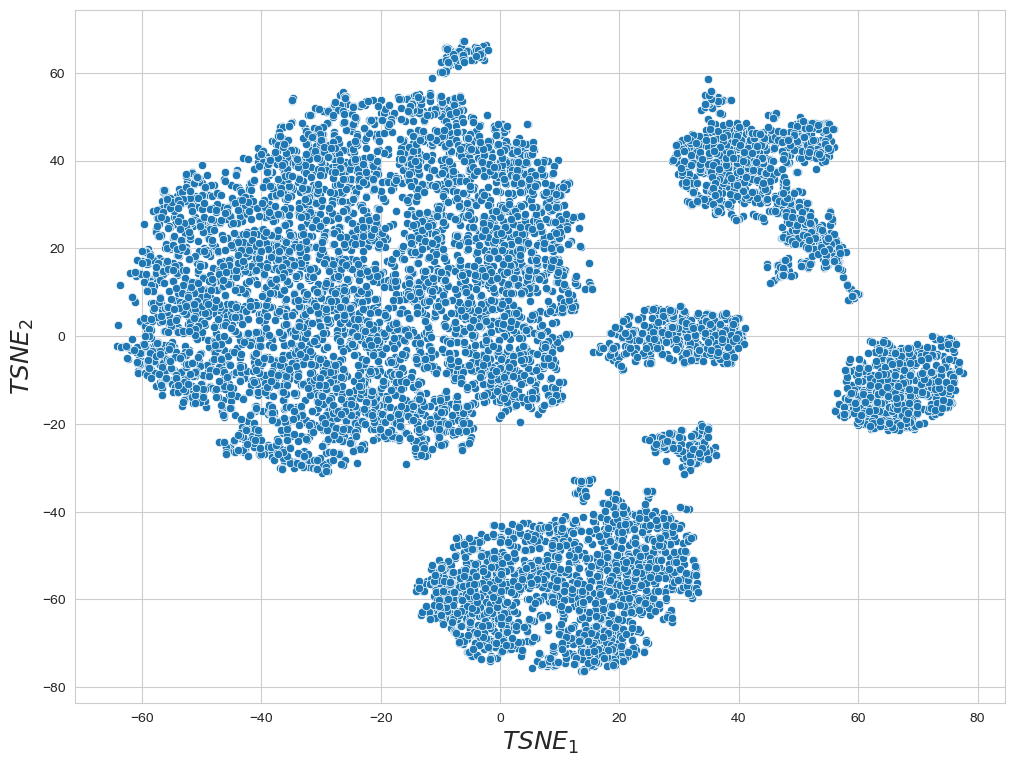

In [9]:
tsne_res = plot_tsne(scaled_fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Я прогоняла это с не стандартизованными данными тоже и визуально там было 5 кластеров. Здесь плот для стандартизованных данных и может показаться, что здесь 6 кластеров, но один довольно маленький и поэтому я использовала n_cluster 5 в алгоритмах ниже.

In [287]:
# k means
k_means = KMeans(n_clusters=5)
k_means.fit(scaled_fc_data)
labels = k_means.labels_
print("K Means: silhouette_score", round(silhouette_score(scaled_fc_data, labels), 3))

K Means: silhouette_score 0.52


In [13]:
# Hierarchical clustering
clust = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
clust.fit(scaled_fc_data)
labels_AC = clust.labels_
print("Hierarchical clustering: silhouette_score", round(silhouette_score(scaled_fc_data, labels_AC), 3))

Hierarchical clustering: silhouette_score 0.5


In [289]:
# DBSCAN
clustering = DBSCAN()
clustering.fit(scaled_fc_data)
labels = clustering.labels_
print("DBSCAN: silhouette_score", round(silhouette_score(scaled_fc_data, labels), 3))

DBSCAN: silhouette_score -0.323


In [290]:
# SpectralClustering
clustering = SpectralClustering()
clustering.fit(scaled_fc_data)
labels = clustering.labels_
print("SpectralClustering: silhouette_score", round(silhouette_score(scaled_fc_data, labels), 3))

SpectralClustering: silhouette_score 0.417


По метрике силуэт Hierarchical clustering показал себя лучше других на не стандартизованных данных (не показано здесь). Здесь использованы стандартизованные данные и k means немного лучше, чем Hierarchical clustering, но не значительно. Я оставила ниже лейблы из Hierarchical clustering.

In [11]:
fc_data['cluster_label'] = labels_AC

Text(0, 0.5, '$TSNE_2$')

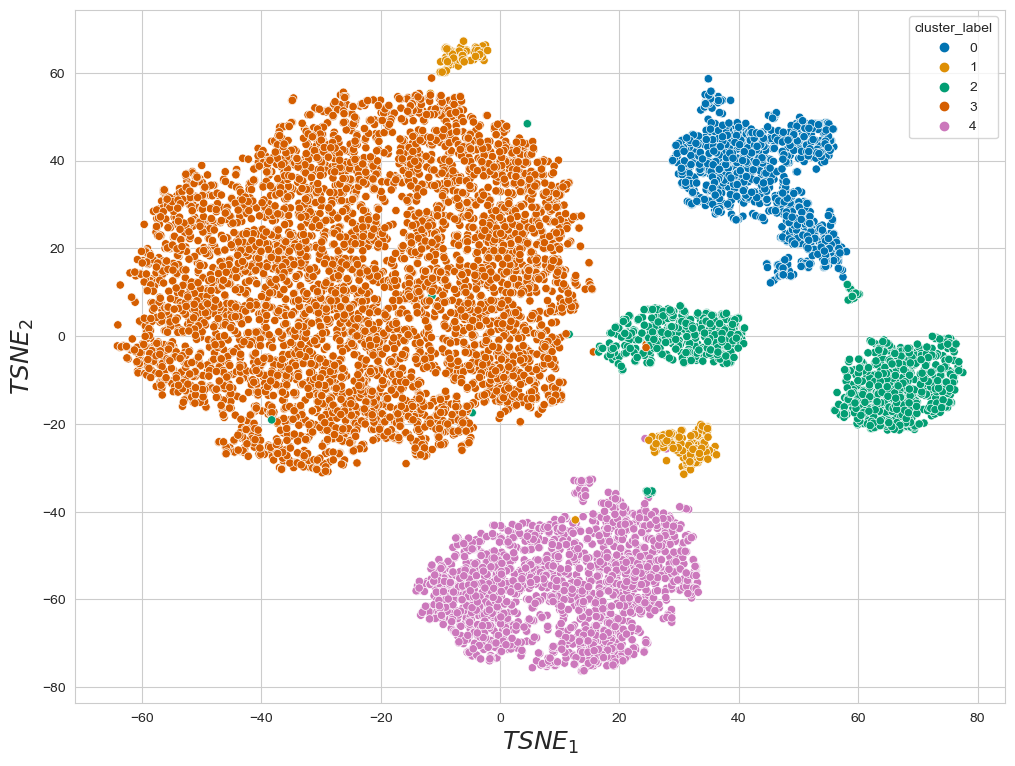

In [14]:
sns.scatterplot(x=tsne_res[:, 0],
                    y=tsne_res[:, 1],
                    hue=fc_data['cluster_label'], palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

За небольшим исключением точки в кластерах покрашены в соответсвии с нашими ожиданиями, то есть алгоритм хорошо разделил кластеры.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

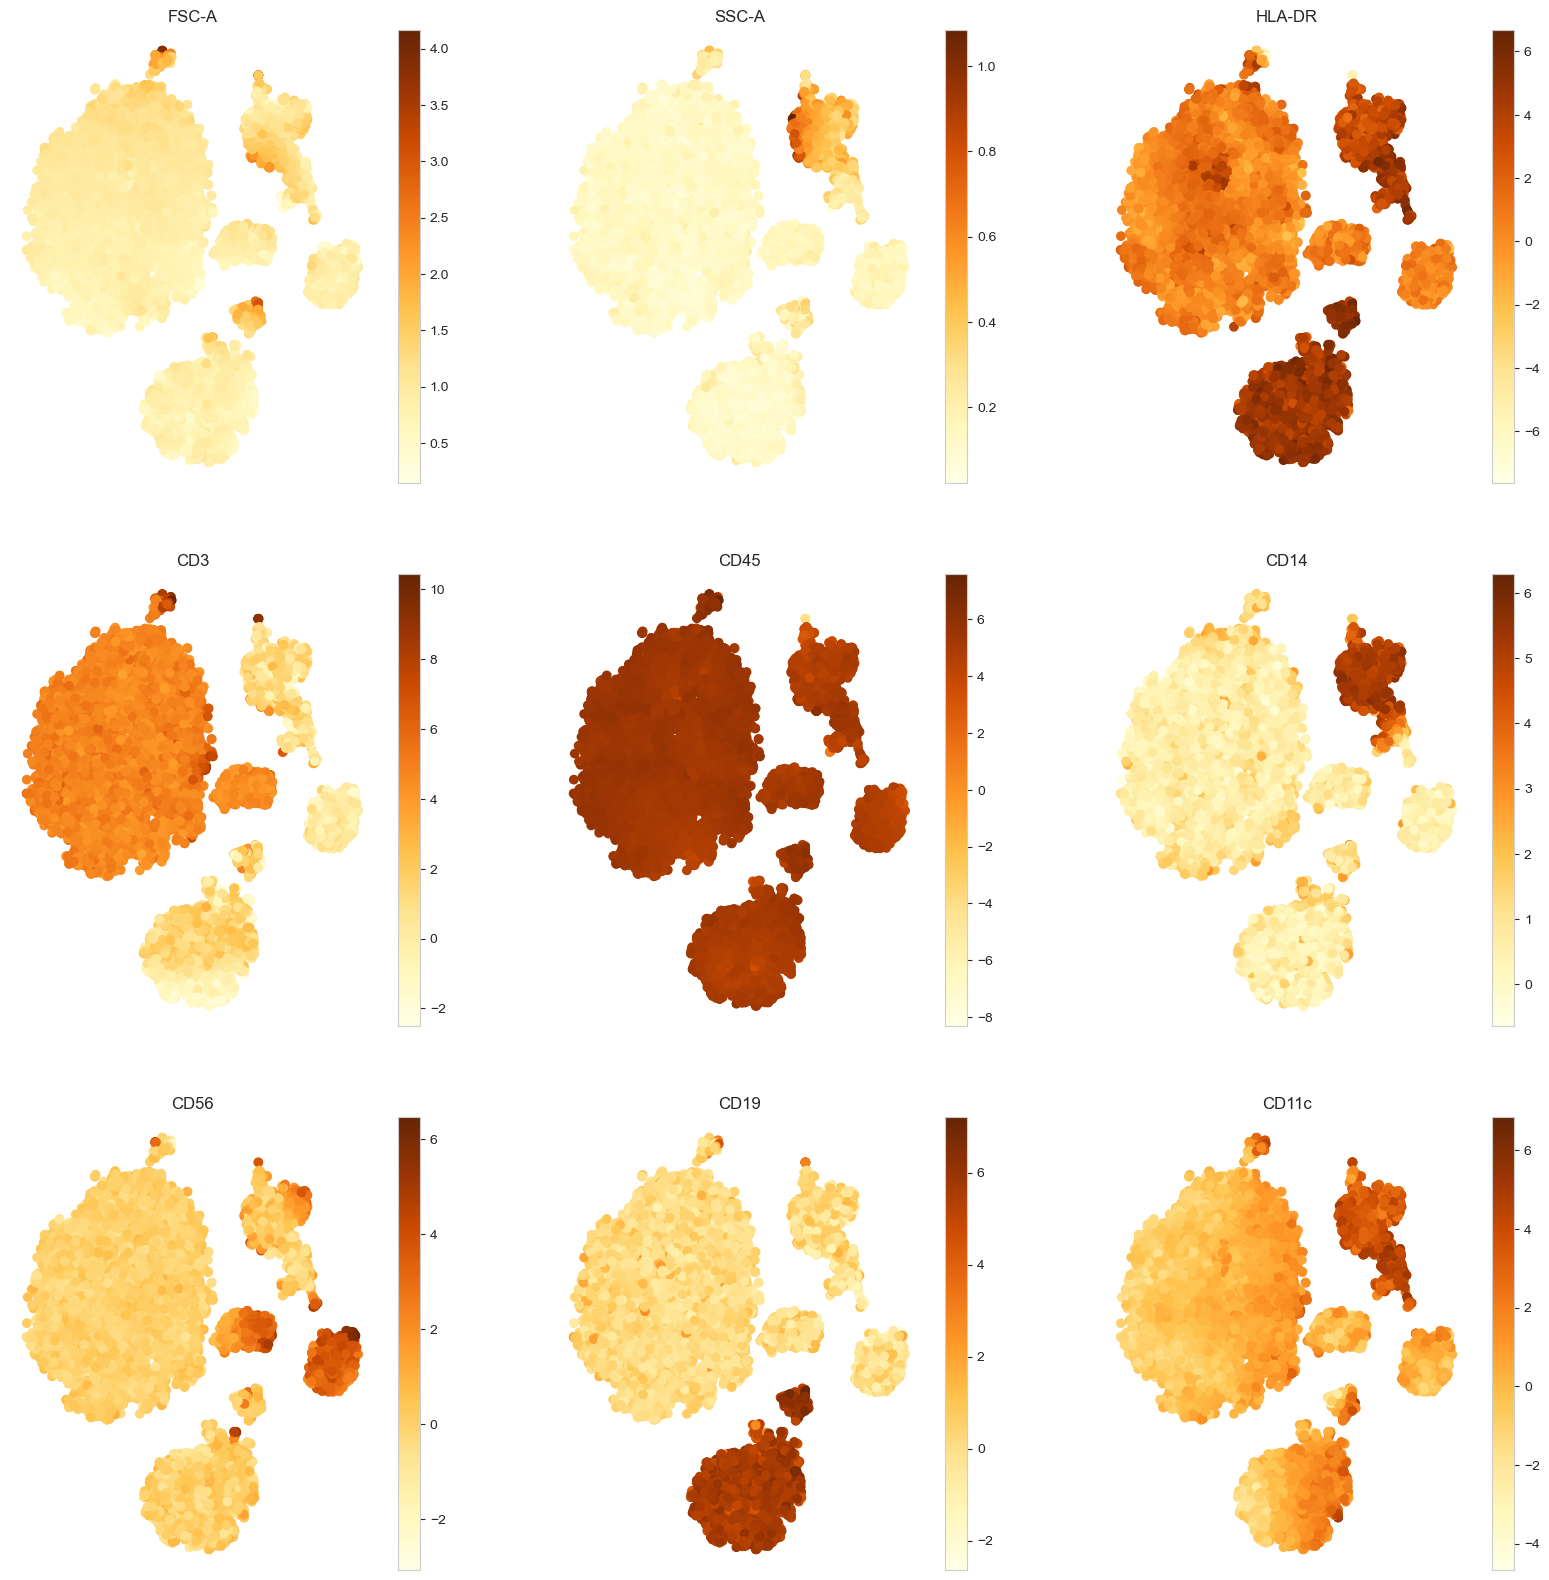

In [15]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [16]:
cell_type_cluster_map = {0: "Monocytes", 
                         1: "Other cells", 
                         2: "Other cells", 
                         3: "T_cells",
                         4: "B_cells"}

In [17]:
labeled_fc_data = fc_data.assign(Population=clust.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [18]:
labeled_fc_data['Population'].value_counts()

T_cells        5657
B_cells        1844
Other cells    1417
Monocytes      1081
Name: Population, dtype: int64

У нас значительно больше Т клеток, типы клеток распределены неравномерно. 

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [21]:
labeled_fc_data.to_csv('labeled_fc_data.csv', index=False)

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

Я использую здесь логистическую регрессию. Ее возможно использовать для небинарных признаков. В отличие от KNN, который запоминает наши данные, логистическая регрессия кажется более продвинутым алгоритмом. Использование KNN для больших датасетов так же может быть менее выгодно вычислительно.

Разделим данные на тренировочные и тестовые. Нам нужна стратификация, так как мы знаем что классы представленны неравномерно.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(labeled_fc_data.iloc[:, :-2], 
                                                    labeled_fc_data[['Population']], 
                                                    test_size=0.2, 
                                                    stratify=labeled_fc_data[['Population']])

In [46]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

array(['Other cells', 'T_cells', 'B_cells', ..., 'T_cells', 'T_cells',
       'T_cells'], dtype=object)

Оценим качество полученной модели при помощи f1_score(average="macro").

In [49]:
f1 = f1_score(y_test, y_pred, average="macro")
f1

0.9840130063755205

Это хороший f1 score, значит модель хорошо определяет классы.

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

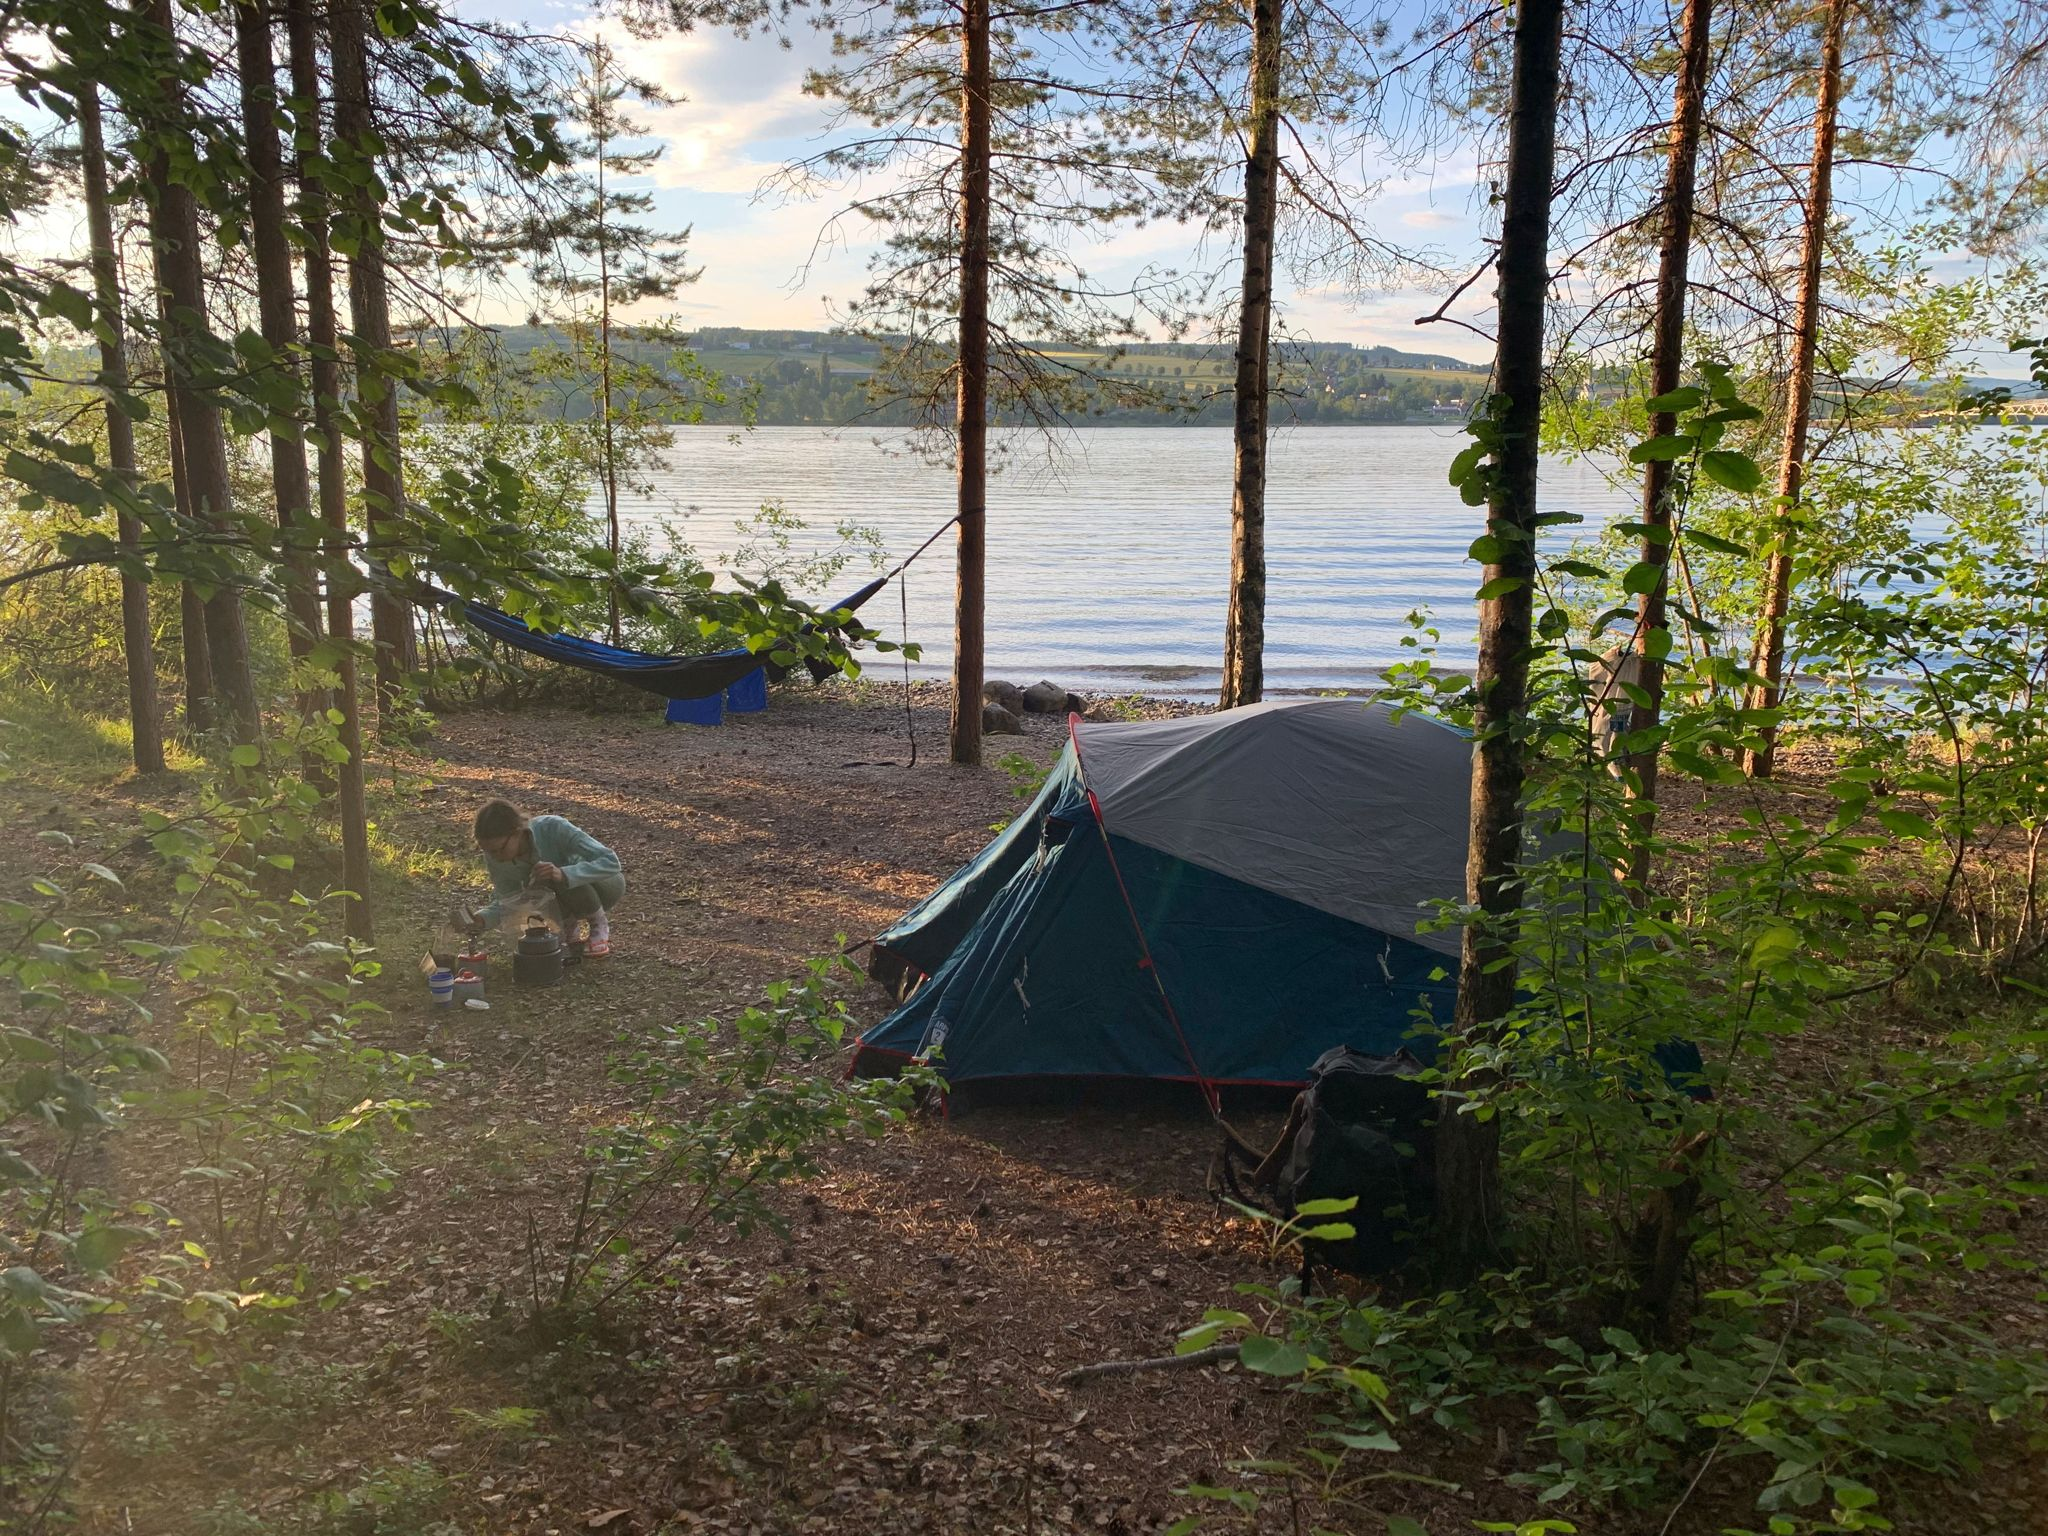

In [54]:
# К сожалению этой весной я никуда не смогу поехать. Но вообще я люблю любое место, где можно отдыхать с палаткой. Очень советую средний Урал, откуда я родом. На фото я летом 2023. 
Image(filename='IMG-20230716-WA0034.jpg', width=600, height=400)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Это задание ощущалось намного проще и понятнее первых двух. Задание с клетками было интересным для меня. В начале скрипта были проблемы в коде задания. Я не сразу разобралась почему не работает np.concatenate(dists, axis=1). Не было очевидно, что ожидается, что мы сделаем решейп. У меня так же не работала визуализация из seaborn без явного прописывания sns.scatterplot(x=X[:, 0], y=X[:, 1]) x и y. Может на будущее можно поправить, чтобы студенты могли скорее перейти к сути задания. 